In [ ]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import tensorflow as ts
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

SEED = 15243
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)

plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BATCH_SIZE = 25
DATA_DIR = r"/content/drive/MyDrive/CSE438/Segmented_Images"
IMG_SIZE = 224
MAX_EPOCHS = 10
class_names = ["Colon benign tissue", "Colon adenocarcinoma"]
class_details = ["No Cancer", "Adenocarcinoma"]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="training",
    validation_split=0.2
)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="validation",
    validation_split=0.2
)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [ ]:
# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache(".cached-data").prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


def compile_and_fit_model(model: tf.keras.Sequential) -> tf.keras.callbacks.History:
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=5,
        mode="auto",
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=0.001
    )
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=MAX_EPOCHS,
        callbacks=[early_stopping, reduce_lr]
    )
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax, metric in zip(axes.flat, ["accuracy", "loss"]):
        performance_df.filter(like=metric).plot(ax=ax)
        ax.set_title(metric.title(), size=15, pad=20)
    return history


def plot_predictions(model: tf.keras.Sequential) -> None:
    plt.figure(figsize=(14, 14))
    for images, labels in train_ds.take(1):
        labels = labels.numpy()
        predicted_labels = np.argmax(model.predict(images), axis=1)
        for i, (actual, pred) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if actual == pred:
                plt.title(class_details[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_details[predicted_labels[i]]}\n"
                          + f"(Actual: {class_details[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

**VGG16**

In [ ]:
pretrained_vgg16_base = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_vgg16_base.trainable = False

vgg16_modell = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.vgg16.preprocess_input),
    pretrained_vgg16_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
vgg16_modell.summary()

Epoch 1/10
96/96 [==============================] - 1355s 14s/step - loss: 0.5477 - accuracy: 0.7046 - val_loss: 0.3936 - val_accuracy: 0.7767 - lr: 0.0010
Epoch 2/10
96/96 [==============================] - 1242s 13s/step - loss: 0.3697 - accuracy: 0.7833 - val_loss: 0.3659 - val_accuracy: 0.7850 - lr: 0.0010
Epoch 3/10
96/96 [==============================] - 1257s 13s/step - loss: 0.3346 - accuracy: 0.7962 - val_loss: 0.3646 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 4/10
96/96 [==============================] - 1253s 13s/step - loss: 0.3211 - accuracy: 0.7992 - val_loss: 0.3781 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 5/10
96/96 [==============================] - 1242s 13s/step - loss: 0.2975 - accuracy: 0.8158 - val_loss: 0.3491 - val_accuracy: 0.7867 - lr: 0.0010
Epoch 6/10
96/96 [==============================] - 1247s 13s/step - loss: 0.2788 - accuracy: 0.8233 - val_loss: 0.3490 - val_accuracy: 0.7883 - lr: 0.0010
Epoch 7/10
96/96 [==============================] - 1236s 13s/st

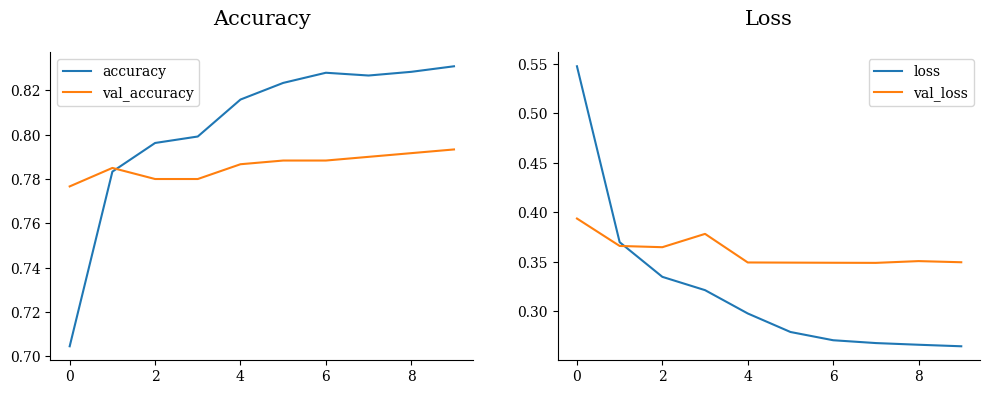

In [ ]:
vgg16_history = compile_and_fit_model(vgg16_modell)

In [ ]:
plot_predictions(vgg16_modell)

**Model with ResNet50 base**

In [ ]:
pretrained_resnet_base = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_resnet_base.trainable = False

resnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input),
    pretrained_resnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
resnet_model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 23,827,459
Trainable params: 262,659
Non-trainable params: 23,564,800
_________________________________________________________________


Epoch 1/10
96/96 [==============================] - 357s 4s/step - loss: 0.4145 - accuracy: 0.7563 - val_loss: 0.3849 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 2/10
96/96 [==============================] - 361s 4s/step - loss: 0.3176 - accuracy: 0.8050 - val_loss: 0.3630 - val_accuracy: 0.7983 - lr: 0.0010
Epoch 3/10
96/96 [==============================] - 354s 4s/step - loss: 0.2930 - accuracy: 0.8050 - val_loss: 0.3498 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 4/10
96/96 [==============================] - 350s 4s/step - loss: 0.2833 - accuracy: 0.8154 - val_loss: 0.3441 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/10
96/96 [==============================] - 347s 4s/step - loss: 0.2730 - accuracy: 0.8200 - val_loss: 0.3521 - val_accuracy: 0.7983 - lr: 0.0010
Epoch 6/10
96/96 [==============================] - 343s 4s/step - loss: 0.2691 - accuracy: 0.8171 - val_loss: 0.3651 - val_accuracy: 0.7950 - lr: 0.0010
Epoch 7/10
96/96 [==============================] - 355s 4s/step - loss: 0.2

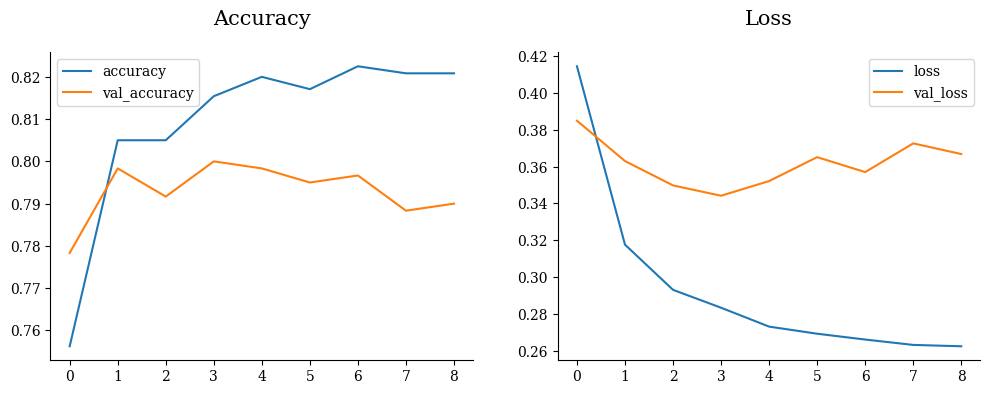

In [ ]:
resnet_history = compile_and_fit_model(resnet_model)

In [ ]:
plot_predictions(resnet_model)

**EfficientNet**

In [ ]:
prerained_efficientnet_base = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False, weights="imagenet", pooling="avg",
)
prerained_efficientnet_base.trainable = False

efficientnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    prerained_efficientnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
efficientnet_model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense_4 (Dense)             (None, 128)               196736    
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 10,980,658
Trainable params: 197,123
Non-trainable params: 10,783,535
_________________________________________________________________


Epoch 1/10
96/96 [==============================] - 328s 3s/step - loss: 0.4133 - accuracy: 0.7558 - val_loss: 0.3780 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 2/10
96/96 [==============================] - 307s 3s/step - loss: 0.3245 - accuracy: 0.8050 - val_loss: 0.3495 - val_accuracy: 0.7950 - lr: 0.0010
Epoch 3/10
96/96 [==============================] - 305s 3s/step - loss: 0.3164 - accuracy: 0.8042 - val_loss: 0.3563 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 4/10
96/96 [==============================] - 308s 3s/step - loss: 0.3089 - accuracy: 0.8054 - val_loss: 0.3343 - val_accuracy: 0.7983 - lr: 0.0010
Epoch 5/10
96/96 [==============================] - 306s 3s/step - loss: 0.2956 - accuracy: 0.8171 - val_loss: 0.3395 - val_accuracy: 0.8017 - lr: 0.0010
Epoch 6/10
96/96 [==============================] - 314s 3s/step - loss: 0.3019 - accuracy: 0.8037 - val_loss: 0.3533 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 7/10
96/96 [==============================] - 310s 3s/step - loss: 0.2

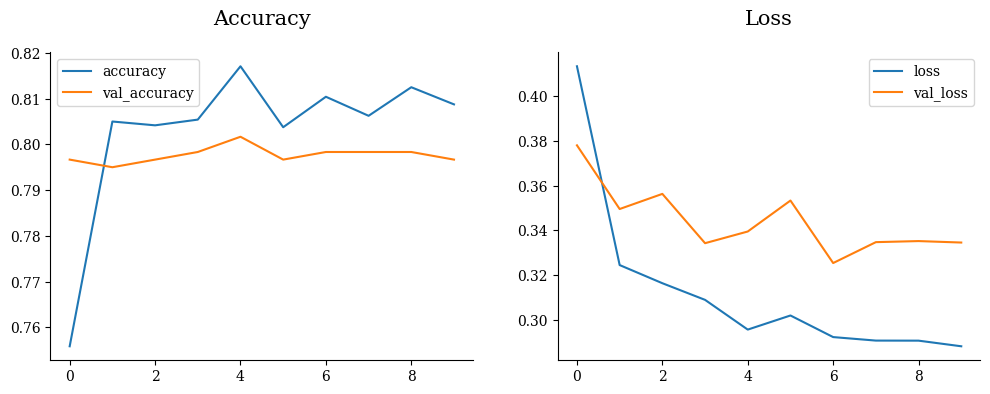

In [ ]:
efficientnet_history = compile_and_fit_model(efficientnet_model)

1/1 [==============================] - 5s 5s/step


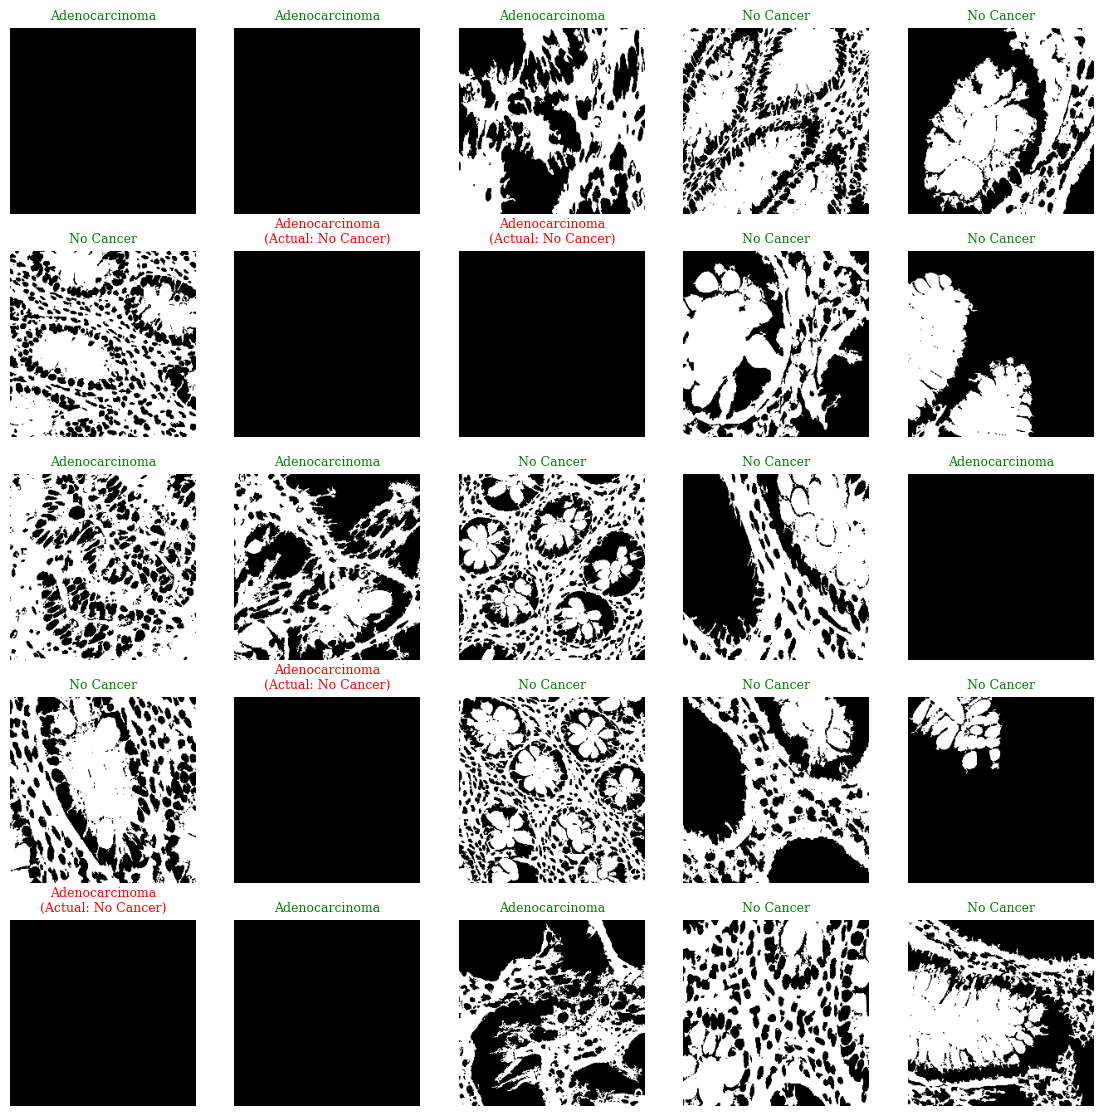

In [ ]:
plot_predictions(efficientnet_model)

**CNN**

In [ ]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range = 20 ,
                                                         horizontal_flip = True ,
                                                         validation_split = 0.25
                                                         )
valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.25)
train_data = train_gen.flow_from_directory(data_dir, subset='training', target_size=(224,224), batch_size=64, color_mode='rgb',
                                            class_mode='categorical', shuffle=True)

val_data = valid_gen.flow_from_directory(data_dir, subset='validation', target_size=(224,224), batch_size=64, color_mode='rgb',
                                            class_mode='categorical', shuffle=False)

In [ ]:
model_1 = keras.models.Sequential()

model_1.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))

model_1.add(keras.layers.Dropout(0.1))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_1.add(keras.layers.Dropout(0.2))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Flatten())
model_1.add(keras.layers.Dense(128, activation='relu'))
model_1.add(keras.layers.Dense(2, activation='softmax'))

model_1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

In [ ]:
history = model.fit_generator(train_data,
          validation_data=val_data,
          epochs = 10)

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report

Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
# calculating and plotting the confusion matrix
cm1 = confusion_matrix(val_data.classes, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()